In [89]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # for derivative
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __sub__(self,other):
        out = Value(self.data - other.data, (self,other), '-')
        def _backward():
            self.grad += out.grad
            other.grad += -out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (2 / (1 + pow(2.718281828459045, -2*n))) - 1
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

In [90]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build (v):
        if v not in nodes: 
            nodes.add(v) 
            for child in v._prev: 
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}"% (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

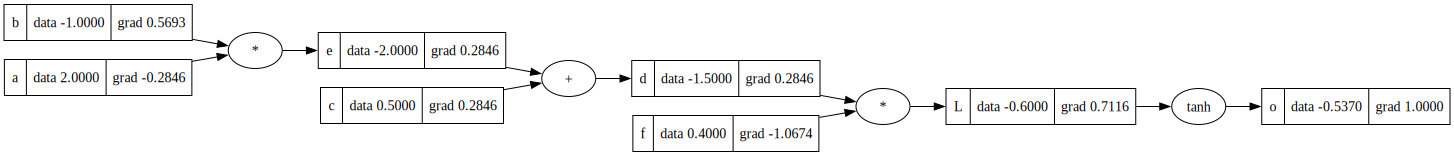

In [ ]:
a = Value(2.0, label='a')
b = Value(-1.0, label='b') 
c = Value(0.5, label='c')

e = a*b; e.label='e'
d = c + e; d.label='d'

f = Value(0.4, label='f')
L = d*f; L.label='L'

o = L.tanh(); o.label='o'

o.grad = 1.0
o.backward()

draw_dot(o)